# Intraday Strategy, Part 1: Feature Engineering

In this notebook, we load the high-quality NASDAQ100 minute-bar trade-and-quote data generously provided by [Algoseek](https://www.algoseek.com/) (available [here](https://www.algoseek.com/ml4t-book-data.html)) and engineer a few illustrative features. 

The rich set of trade and quote information contained in the Algoseek data offers various opportunities to add inforation, e.g. about relative spreads and demand/supply imbalances, but since the data is fairly large we limit our efforts to a small number of features.

> Note that we will assume throughout that we can always buy (sell) at the first (last) trade price for a given bar at no cost and without market impact; this is unlikely to be true in reality but simplifies the example).

The next notebook will use this dataset to train a model that predicts 1-minute returns using LightGBM.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

from scipy.stats import spearmanr
import talib

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1)

## Algoseek Trade & Quote Minute Bar Data

### Data Dictionary

The Quote fields are based on changes to the NBBO ([National Best Bid Offer](https://www.investopedia.com/terms/n/nbbo.asp)) from the top-of-book price and size from
each of the exchanges.

The enhanced Trade & Quote bar fields include the following fields:
- **Field**: Name of Field.
- **Q / T**: Field based on Quotes or Trades
- **Type**: Field format
- **No Value**: Value of field when there is no value or data. 
  - Note: “Never” means field should always have a value EXCEPT for the first bar of the day.
- **Description**: Description of the field.

See [docs](https://us-equity-market-data-docs.s3.amazonaws.com/algoseek.US.Equity.TAQ.Minute.Bars.pdf) for additional detail.

| id  | Field                   | Q/T  | Type                          |  No Value | Description                                                                                                                                                                                                         |
|:---:|:------------------------|:----:|:------------------------------|:---------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1  | `Date`                   |      | YYYYMMDD                      | Never     | Trade Date                                                                                                                                                                                                          |
| 2  | `Ticker`                 |      | String                       | Never      | Ticker Symbol                                                                                                                                                                                                       |
| 3  | `TimeBarStart`           |      | HHMM <br>HHMMSS <br>HHMMSSMMM | Never     | For minute bars: HHMM. <br>For second bars: HHMMSS. <br>Examples<br>- One second bar 130302 is from time greater than 130301 to 130302.<br>- One minute bar 1104 is from time greater than 1103 to 1104. |
| 4  | `OpenBarTime`            | Q    | HHMMSSMMM                    | Never      | Open Time of the Bar, for example one minute:<br>11:03:00.000                                                                                                                                                       |
| 5  | `OpenBidPrice`           | Q    | Number                        | Never     | NBBO Bid Price as of bar Open                                                                                                                                                                                       |
| 6  | `OpenBidSize`            | Q    | Number                        | Never     | Total Size from all Exchanges with<br>OpenBidPrice                                                                                                                                                                  |
| 7  | `OpenAskPrice`           | Q    | Number                        | Never     | NBBO Ask Price as of bar Open                                                                                                                                                                                       |
| 8  | `OpenAskSize`            | Q    | Number                        | Never     | Total Size from all Exchange with<br>OpenAskPrice                                                                                                                                                                   |
| 9  | `FirstTradeTime`         | T    | HHMMSSMMM                     | Blank     | Time of first Trade                                                                                                                                                                                                 |
| 10 | `FirstTradePrice`        | T    | Number                        | Blank     | Price of first Trade                                                                                                                                                                                                |
| 11 | `FirstTradeSize`         | T    | Number                        | Blank     | Number of shares of first trade                                                                                                                                                                                     |
| 12 | `HighBidTime`            | Q    | HHMMSSMMM                     | Never     | Time of highest NBBO Bid Price                                                                                                                                                                                      |
| 13 | `HighBidPrice`           | Q    | Number                        | Never     | Highest NBBO Bid Price                                                                                                                                                                                              |
| 14 | `HighBidSize`            | Q    | Number                        | Never     | Total Size from all Exchanges with HighBidPrice                                                                                                                                                                  |
| 15 | `AskPriceAtHighBidPrice` | Q    | Number                        | Never     | Ask Price at time of Highest Bid Price                                                                                                                                                                              |
| 16 | `AskSizeAtHighBidPrice`  | Q    | Number                        | Never     | Total Size from all Exchanges with `AskPriceAtHighBidPrice`                                                                                                                                                        |
| 17 | `HighTradeTime`          | T    | HHMMSSMMM                     | Blank     | Time of Highest Trade                                                                                                                                                                                               |
| 18 | `HighTradePrice`         | T    | Number                        | Blank     | Price of highest Trade                                                                                                                                                                                              |
| 19 | `HighTradeSize`          | T    | Number                        | Blank     | Number of shares of highest trade                                                                                                                                                                                   |
| 20 | `LowBidTime`             | Q    | HHMMSSMMM                     | Never     | Time of lowest Bid                                                                                                                                                                                                  |
| 21 | `LowBidPrice`            | Q    | Number                        | Never     | Lowest NBBO Bid price of bar.                                                                                                                                                                                       |
| 22 | `LowBidSize`             | Q    | Number                        | Never     | Total Size from all Exchanges with `LowBidPrice`                                                                                                                                                                   |
| 23 | `AskPriceAtLowBidPrice`  | Q    | Number                        | Never     | Ask Price at lowest Bid price                                                                                                                                                                                       |
| 24  | `AskSizeAtLowBidPrice`  | Q    | Number                        | Never     | Total Size from all Exchanges with `AskPriceAtLowBidPrice`                                                                                                                                                                                       |
| 25  | `LowTradeTime`          | T    | HHMMSSMMM                     | Blank     | Time of lowest Trade                                                                                                                                                                                                                             |
| 26  | `LowTradePrice`         | T    | Number                        | Blank     | Price of lowest Trade                                                                                                                                                                                                                            |
| 27  | `LowTradeSize`          | T    | Number                        | Blank     | Number of shares of lowest trade                                                                                                                                                                                                                 |
| 28  | `CloseBarTime`          | Q    | HHMMSSMMM                     | Never     | Close Time of the Bar, for example one minute: 11:03:59.999                                                                                                                                                                                      |
| 29  | `CloseBidPrice`         | Q    | Number                        | Never     | NBBO Bid Price at bar Close                                                                                                                                                                                                                      |
| 30  | `CloseBidSize`          | Q    | Number                        | Never     | Total Size from all Exchange with `CloseBidPrice`                                                                                                                                                                                                |
| 31  | `CloseAskPrice`         | Q    | Number                        | Never     | NBBO Ask Price at bar Close                                                                                                                                                                                                                      |
| 32  | `CloseAskSize`          | Q    | Number                        | Never     | Total Size from all Exchange with `CloseAskPrice`                                                                                                                                                                                                |
| 33  | `LastTradeTime`         | T    | HHMMSSMMM                     | Blank     | Time of last Trade                                                                                                                                                                                                                               |
| 34  | `LastTradePrice`        | T    | Number                        | Blank     | Price of last Trade                                                                                                                                                                                                                              |
| 35  | `LastTradeSize`         | T    | Number                        | Blank     | Number of shares of last trade                                                                                                                                                                                                                   |
| 36  | `MinSpread`             | Q    | Number                        | Never     | Minimum Bid-Ask spread size. This may be 0 if the market was crossed during the bar.<br/>If negative spread due to back quote, make it 0.                                                                                                            |
| 37  | `MaxSpread`             | Q    | Number                        | Never     | Maximum Bid-Ask spread in bar                                                                                                                                                                                                                    |
| 38  | `CancelSize`            | T    | Number                        | 0         | Total shares canceled. Default=blank                                                                                                                                                                                                             |
| 39  | `VolumeWeightPrice`     | T    | Number                        | Blank     | Trade Volume weighted average price <br>Sum((`Trade1Shares`*`Price`)+(`Trade2Shares`*`Price`)+…)/`TotalShares`. <br>Note: Blank if no trades.                                                                                                        |
| 40  | `NBBOQuoteCount`        | Q    | Number                        | 0         | Number of Bid and Ask NNBO quotes during bar period.                                                                                                                                                                                             |
| 41  | `TradeAtBid`            | Q,T  | Number                        | 0         | Sum of trade volume that occurred at or below the bid (a trade reported/printed late can be below current bid).                                                                                                                                  |
| 42  | `TradeAtBidMid`         | Q,T  | Number                        | 0         | Sum of trade volume that occurred between the bid and the mid-point:<br/>(Trade Price > NBBO Bid ) & (Trade Price < NBBO Mid )                                                                                                                       |
| 43  | `TradeAtMid`            | Q,T  | Number                        | 0         | Sum of trade volume that occurred at mid.<br/>TradePrice = NBBO MidPoint                                                                                                                                                                             |
| 44  | `TradeAtMidAsk`         | Q,T  | Number                        | 0         | Sum of ask volume that occurred between the mid and ask:<br/>(Trade Price > NBBO Mid) & (Trade Price < NBBO Ask)                                                                                                                                     |
| 45  | `TradeAtAsk`            | Q,T  | Number                        | 0         | Sum of trade volume that occurred at or above the Ask.                                                                                                                                                                                           |
| 46  | `TradeAtCrossOrLocked`  | Q,T  | Number                        | 0         | Sum of trade volume for bar when national best bid/offer is locked or crossed. <br>Locked is Bid = Ask <br>Crossed is Bid > Ask                                                                                                                  |
| 47  | `Volume`                | T    | Number                        | 0         | Total number of shares traded                                                                                                                                                                                                                    |
| 48  | `TotalTrades`           | T    | Number                        | 0         | Total number of trades                                                                                                                                                                                                                           |
| 49  | `FinraVolume`           | T    | Number                        | 0         | Number of shares traded that are reported by FINRA. <br/>Trades reported by FINRA are from broker-dealer internalization, dark pools, Over-The-Counter, etc. <br/>FINRA trades represent volume that is hidden or not public available to trade.         |
| 50  | `UptickVolume`          | T    | Integer                       | 0         | Total number of shares traded with upticks during bar.<br/>An uptick = ( trade price > last trade price )                                                                                                                                                                                                                               |
| 51  | `DowntickVolume`        | T    | Integer                       | 0         | Total number of shares traded with downticks during bar.<br/>A downtick = ( trade price < last trade price )                                                                                                                                                                                                                            |
| 52  | `RepeatUptickVolume`    | T    | Integer                       | 0         | Total number of shares where trade price is the same (repeated) and last price change was up during bar. <br/>Repeat uptick = ( trade price == last trade price ) & (last tick direction == up )                                                                                                                                         |
| 53  | `RepeatDowntickVolume`  | T    | Integer                       | 0         | Total number of shares where trade price is the same (repeated) and last price change was down during bar. <br/>Repeat downtick = ( trade price == last trade price ) & (last tick direction == down )                                                                                                                                   |
| 54  | `UnknownVolume`         | T    | Integer                       | 0         | When the first trade of the day takes place, the tick direction is “unknown” as there is no previous Trade to compare it to.<br/>This field is the volume of the first trade after 4am and acts as an initiation value for the tick volume directions.<br/>In future this bar will be renamed to `UnkownTickDirectionVolume` .  |

### Notes

**Empty Fields**

An empty field has no value and is “Blank” , for example FirstTradeTime and there are no trades during the bar period. 
The field `Volume` measuring total number of shares traded in bar will be `0` if there are no Trades (see `No Value` column above for each field).

**No Bid/Ask/Trade OHLC**

During a bar timeframe there may not be a change in the NBBO or an actual Trade. 
For example, there can be a bar with OHLC Bid/Ask but no Trade OHLC.

**Single Event**

For bars with only one trade, one NBBO bid or one NBBO ask then Open/High/Low/Close price,size andtime will be the same.

**`AskPriceAtHighBidPrice`, `AskSizeAtHighBidPrice`, `AskPriceAtLowBidPrice`, `AskSizeAtLowBidPrice` Fields** 

To provide consistent Bid/Ask prices at a point in time while showing the low/high Bid/Ask for the bar, AlgoSeek uses the low/high `Bid` and the corresponding `Ask` at that price.

### FAQ

**Why are Trade Prices often inside the Bid Price to Ask Price range?**

The Low/High Bid/Ask is the low and high NBBO price for the bar range. 
Very often a Trade may not occur at these prices as the price may only last a few seconds or executions are being crossed at mid-point due to hidden order types that execute at mid-point or as price improvement over current `Bid`/`Ask`.

**How to get exchange tradable shares?** 

To get the exchange tradable volume in a bar subtract `Volume` from `FinraVolume`. 
- `Volume` is the total number of shares traded. 
- ``FinraVolume`` is the total number of shares traded that are reported as executions by FINRA. 

When a trade is done that is off the listed exchanges, it must be reported to FINRA by the brokerage firm or dark pool. Examples include: 
- internal crosses by broker dealer
- over-the-counter block trades, and
- dark pool executions.

## Data prep

We use the 'Trade and Quote' dataset - see [documentation](https://www.algoseek.com/old_static/files/documentation/equity_and_etf_etn/AlgoSeek.US.Equity.TradeAndQuotes.OHLC.Bars.1.5.pdf) for details on the definition of the numerous fields.

In [4]:
tcols = ['openbartime', 
         'firsttradetime',
         'highbidtime', 
         'highasktime', 
         'hightradetime',
         'lowbidtime', 
         'lowasktime', 
         'lowtradetime',
         'closebartime', 
         'lasttradetime']

In [5]:
drop_cols = ['unknowntickvolume',
             'cancelsize',
             'tradeatcrossorlocked']

In [6]:
keep = ['firsttradeprice', 
        'hightradeprice', 
        'lowtradeprice', 
        'lasttradeprice', 
        'minspread', 
        'maxspread',
        'volumeweightprice', 
        'nbboquotecount', 
        'tradeatbid', 
        'tradeatbidmid', 
        'tradeatmid', 
        'tradeatmidask', 
        'tradeatask', 
        'volume', 
        'totaltrades', 
        'finravolume', 
        'finravolumeweightprice', 
        'uptickvolume', 
        'downtickvolume', 
        'repeatuptickvolume', 
        'repeatdowntickvolume', 
        'tradetomidvolweight', 
        'tradetomidvolweightrelative']

We will shorten most of the field names to reduce typing:

In [7]:
columns = {'volumeweightprice'          : 'price',
           'finravolume'                : 'fvolume',
           'finravolumeweightprice'     : 'fprice',
           'uptickvolume'               : 'up',
           'downtickvolume'             : 'down',
           'repeatuptickvolume'         : 'rup',
           'repeatdowntickvolume'       : 'rdown',
           'firsttradeprice'            : 'first',
           'hightradeprice'             : 'high',
           'lowtradeprice'              : 'low',
           'lasttradeprice'             : 'last',
           'nbboquotecount'             : 'nbbo',
           'totaltrades'                : 'ntrades',
           'openbidprice'               : 'obprice',
           'openbidsize'                : 'obsize',
           'openaskprice'               : 'oaprice',
           'openasksize'                : 'oasize',
           'highbidprice'               : 'hbprice',
           'highbidsize'                : 'hbsize',
           'highaskprice'               : 'haprice',
           'highasksize'                : 'hasize',
           'lowbidprice'                : 'lbprice',
           'lowbidsize'                 : 'lbsize',
           'lowaskprice'                : 'laprice',
           'lowasksize'                 : 'lasize',
           'closebidprice'              : 'cbprice',
           'closebidsize'               : 'cbsize',
           'closeaskprice'              : 'caprice',
           'closeasksize'               : 'casize',
           'firsttradesize'             : 'firstsize',
           'hightradesize'              : 'highsize',
           'lowtradesize'               : 'lowsize',
           'lasttradesize'              : 'lastsize',
           'tradetomidvolweight'        : 'volweight',
           'tradetomidvolweightrelative': 'volweightrel'}

The Algoseek minute-bar data comes in compressed csv files that contain the data for one symbol and day, organized in three directories for each year (2015-17). The function `extract_and_combine_data` reads the ~80K source files and combines them into a single `hdf5` file for faster access. 

>The data is fairly large (>8GB), and if you run into memory constraints, please modify the code to process the data in smaller chunks. One options is to iterate over the three directories containing data for a single year only, and storing each year separately.

In [8]:
nasdaq_path = Path('../data/nasdaq100')

In [9]:
def extract_and_combine_data():
    path = nasdaq_path / '1min_taq'

    data = []
    # ~80K files to process
    for f in tqdm(list(path.glob('*/**/*.csv.gz'))):
        data.append(pd.read_csv(f, parse_dates=[['Date', 'TimeBarStart']])
                    .rename(columns=str.lower)
                    .drop(tcols + drop_cols, axis=1)
                    .rename(columns=columns)
                    .set_index('date_timebarstart')
                    .sort_index()
                    .between_time('9:30', '16:00')
                    .set_index('ticker', append=True)
                    .swaplevel()
                    .rename(columns=lambda x: x.replace('tradeat', 'at')))
    data = pd.concat(data).apply(pd.to_numeric, downcast='integer')
    data.index.rename(['ticker', 'date_time'])
    print(data.info(show_counts=True))
    data.to_hdf(nasdaq_path / 'algoseek.h5', 'min_taq')

In [10]:
# extract_and_combine_data()

## Loading Algoseek Data

In [4]:
ohlcv_cols = ['first', 'high', 'low', 'last', 'price', 'volume']

In [5]:
data_cols = ohlcv_cols + ['up', 'down', 'rup', 'rdown', 'atask', 'atbid']

In [8]:
data_path = 'E:/ML4T/C2/algoseek-intraday/algoseek.h5'
with pd.HDFStore(data_path) as store:
    df = store['min_taq'].loc[:, data_cols].sort_index()

In [9]:
df['date'] = pd.to_datetime(df.index.get_level_values('date_time').date)

We persist the reduced dataset:

In [10]:
df.to_hdf(data_path, 'data')

In [11]:
df = pd.read_hdf(data_path, 'data')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31355463 entries, ('AAL', Timestamp('2015-01-02 09:30:00')) to ('YHOO', Timestamp('2017-06-16 16:00:00'))
Data columns (total 13 columns):
 #   Column  Dtype         
---  ------  -----         
 0   first   float64       
 1   high    float64       
 2   low     float64       
 3   last    float64       
 4   price   float64       
 5   volume  int32         
 6   up      int32         
 7   down    int32         
 8   rup     int32         
 9   rdown   int32         
 10  atask   int32         
 11  atbid   int32         
 12  date    datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int32(7)
memory usage: 2.4+ GB


## Feature Engineering

All of the features above were normalized in a standard fashion
by subtracting their means, dividing by their standard deviations, and time-averaging over a recent
interval. In order to obtain a finite state space, features were discretized into bins in multiples of
standard deviation units

We will compute feature per ticker or ticker and date:

In [14]:
by_ticker = df.sort_index().groupby('ticker', group_keys=False)
by_ticker_date = df.sort_index().groupby(['ticker', 'date'])

Create empty `DataFrame` with original ticker/timestamp index to hold our features:

In [15]:
data = pd.DataFrame(index=df.index)

In [16]:
data['date'] = pd.factorize(df['date'], sort=True)[0]

In [17]:
data['minute'] = pd.to_timedelta(data.index.get_level_values('date_time').time.astype(str))
data.minute = (data.minute.dt.seconds.sub(data.minute.dt.seconds.min()).div(60).astype(int))

### Lagged Returns

We create lagged returns with respect to first and last price per bar for each the past 10 minutes:

In [18]:
data[f'ret1min'] = df['last'].div(df['first']).sub(1)

1-min returns have rather heavy tails:

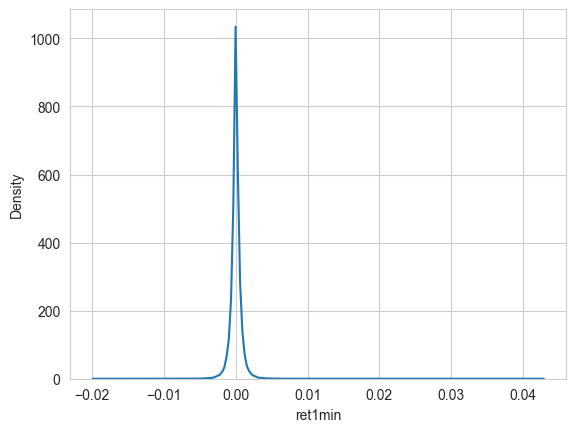

In [19]:
sns.kdeplot(data.ret1min.sample(n=100000));

In [20]:
data.ret1min.describe(percentiles=np.arange(.1, 1, .1)).iloc[1:].apply(lambda x: f'{x:.3%}')

mean     -0.000%
std       0.086%
min     -12.448%
10%      -0.075%
20%      -0.041%
30%      -0.023%
40%      -0.009%
50%       0.000%
60%       0.009%
70%       0.022%
80%       0.040%
90%       0.074%
max      13.392%
Name: ret1min, dtype: object

In [21]:
print(f'Skew: {data.ret1min.skew():.2f} | Kurtosis: {data.ret1min.kurtosis():.2f}')

Skew: 0.63 | Kurtosis: 399.53


Intra-bar price moves with the highest returns:

In [22]:
data.join(df[['first', 'last']]).nlargest(10, columns=['ret1min'])

,,date,minute,ret1min,first,last
ticker,date_time,,,,,
TSCO,2016-12-22 10:01:00,498,31,0.133921,68.1000,77.2200
AMGN,2017-03-06 15:46:00,546,376,0.132842,158.7600,179.8500
LILA,2015-07-02 09:39:00,125,9,0.121998,50.0001,56.1000
BIDU,2015-08-24 09:32:00,161,2,0.119729,111.2300,124.5475
NXPI,2016-09-29 13:10:00,439,220,0.119144,81.7500,91.4900
HSIC,2015-10-26 15:38:00,205,368,0.105501,135.0700,149.3200
CELG,2015-08-24 09:35:00,161,5,0.100645,93.0000,102.3600
LILAK,2015-07-02 09:38:00,125,8,0.098778,50.0101,54.9500
CTRP,2017-12-11 10:51:00,741,81,0.097899,43.3100,47.5500


We compute similarly for the remaining periods:

In [23]:
for t in tqdm(range(2, 11)):
    data[f'ret{t}min'] = df['last'].div(by_ticker_date['first'].shift(t-1)).sub(1)

100%|██████████| 9/9 [00:12<00:00,  1.39s/it]


### Forward Returns

We obtain our 1-min forward return target by shifting the one-period return by one minute into the past (which implies the assumption that we always enter and exit a position at those prices, also ignoring trading cost and potential market impact):

In [24]:
data['fwd1min'] = (data
                   .sort_index()
                   .groupby(['ticker', 'date'])
                   .ret1min
                   .shift(-1))

In [25]:
data = data.dropna(subset=['fwd1min'])

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30875649 entries, ('AAL', Timestamp('2015-01-02 09:30:00')) to ('YHOO', Timestamp('2017-06-16 15:59:00'))
Data columns (total 13 columns):
 #   Column    Dtype  
---  ------    -----  
 0   date      int64  
 1   minute    int32  
 2   ret1min   float64
 3   ret2min   float64
 4   ret3min   float64
 5   ret4min   float64
 6   ret5min   float64
 7   ret6min   float64
 8   ret7min   float64
 9   ret8min   float64
 10  ret9min   float64
 11  ret10min  float64
 12  fwd1min   float64
dtypes: float64(11), int32(1), int64(1)
memory usage: 3.1+ GB


### Normalized up/downtick volume

In [28]:
for f in ['up', 'down', 'rup', 'rdown']:
    data[f] = df.loc[:, f].div(df.volume).replace(np.inf, np.nan)

In [29]:
data.loc[:, ['rup', 'up', 'rdown', 'down']].describe(deciles)

,rup,up,rdown,down
count,3.008378e+07,3.008378e+07,3.008378e+07,3.008378e+07
mean,5.115708e-01,7.005788e-01,5.133731e-01,7.195690e-01
std,1.574588e+01,3.330319e+01,1.715537e+01,3.393822e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
10%,0.000000e+00,6.575102e-02,0.000000e+00,6.686489e-02
20%,9.647853e-02,1.111111e-01,9.905957e-02,1.129661e-01
30%,1.980198e-01,1.521226e-01,2.012931e-01,1.546516e-01
40%,2.859422e-01,1.957295e-01,2.914713e-01,1.992032e-01
50%,3.702796e-01,2.457865e-01,3.758913e-01,2.500000e-01
60%,4.582528e-01,3.063010e-01,4.637681e-01,3.122179e-01


### Balance of Power

In [30]:
data['BOP'] = (by_ticker.apply(lambda x: talib.BOP(x['first'],
                                                   x.high,
                                                   x.low,
                                                   x['last'])))

###  Commodity Channel Index

In [31]:
data['CCI'] = (by_ticker.apply(lambda x: talib.CCI(x.high,
                                          x.low,
                                          x['last'],
                                          timeperiod=14)))

### Money Flow Index

In [32]:
data['MFI'] = (by_ticker.apply(lambda x: talib.MFI(x.high,
                                          x.low,
                                          x['last'],
                                          x.volume,
                                          timeperiod=14)))

In [33]:
data[['BOP', 'CCI', 'MFI']].describe(deciles)

,BOP,CCI,MFI
count,3.061285e+07,2.851777e+07,3.087372e+07
mean,-2.087998e-03,3.296217e-01,4.997376e+01
std,6.266554e-01,1.088812e+02,1.969084e+01
min,-1.000000e+00,-4.666667e+02,-1.116565e-06
10%,-9.000000e-01,-1.376036e+02,2.396008e+01
20%,-6.633333e-01,-9.977407e+01,3.241035e+01
30%,-4.500000e-01,-6.911730e+01,3.886505e+01
40%,-1.818182e-01,-3.690746e+01,4.454481e+01
50%,0.000000e+00,7.306860e-01,4.992163e+01
60%,1.672241e-01,3.807433e+01,5.531387e+01


### Stochastic RSI

In [34]:
data['STOCHRSI'] = (by_ticker.apply(lambda x: talib.STOCHRSI(x['last'].ffill(),
                                                             timeperiod=14,
                                                             fastk_period=14,
                                                             fastd_period=3,
                                                             fastd_matype=0)[0]))

### Stochastic Oscillator

In [35]:
def compute_stoch(x, fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0):
    slowk, slowd = talib.STOCH(x.high.ffill(), x.low.ffill(), x['last'].ffill(), 
                               fastk_period=fastk_period,
                               slowk_period=slowk_period,
                               slowk_matype=slowk_matype,
                               slowd_period=slowd_period,
                               slowd_matype=slowd_matype)
    return pd.DataFrame({'slowd': slowd, 
                         'slowk': slowk}, 
                        index=x.index)

In [36]:
data = data.join(by_ticker.apply(compute_stoch))

### Average True Range

In [37]:
data['NATR'] = by_ticker.apply(lambda x: talib.NATR(x.high.ffill(), 
                                                    x.low.ffill(), 
                                                    x['last'].ffill()))

### Transaction Volume by price point

In [38]:
data['trades_bid_ask'] = df.atask.sub(df.atbid).div(df.volume).replace((np.inf, -np.inf), np.nan)

In [39]:
del df

In [40]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30875649 entries, ('AAL', Timestamp('2015-01-02 09:30:00')) to ('YHOO', Timestamp('2017-06-16 15:59:00'))
Data columns (total 25 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   date            30875649 non-null  int64  
 1   minute          30875649 non-null  int32  
 2   ret1min         30612848 non-null  float64
 3   ret2min         30302846 non-null  float64
 4   ret3min         30220887 non-null  float64
 5   ret4min         30141503 non-null  float64
 6   ret5min         30063236 non-null  float64
 7   ret6min         29983969 non-null  float64
 8   ret7min         29903822 non-null  float64
 9   ret8min         29824607 non-null  float64
 10  ret9min         29745431 non-null  float64
 11  ret10min        29666821 non-null  float64
 12  fwd1min         30875649 non-null  float64
 13  up              30083777 non-null  float64
 14  down            30083777 non-null  flo

### Evaluate features

In [41]:
features = ['ret1min', 'ret2min', 'ret3min', 'ret4min', 'ret5min', 
            'ret6min', 'ret7min', 'ret8min', 'ret9min', 'ret10min',
            'rup', 'up', 'down', 'rdown', 'BOP', 'CCI', 'MFI', 'STOCHRSI', 
            'slowk', 'slowd', 'trades_bid_ask']

In [42]:
sample = data.sample(n=100000)

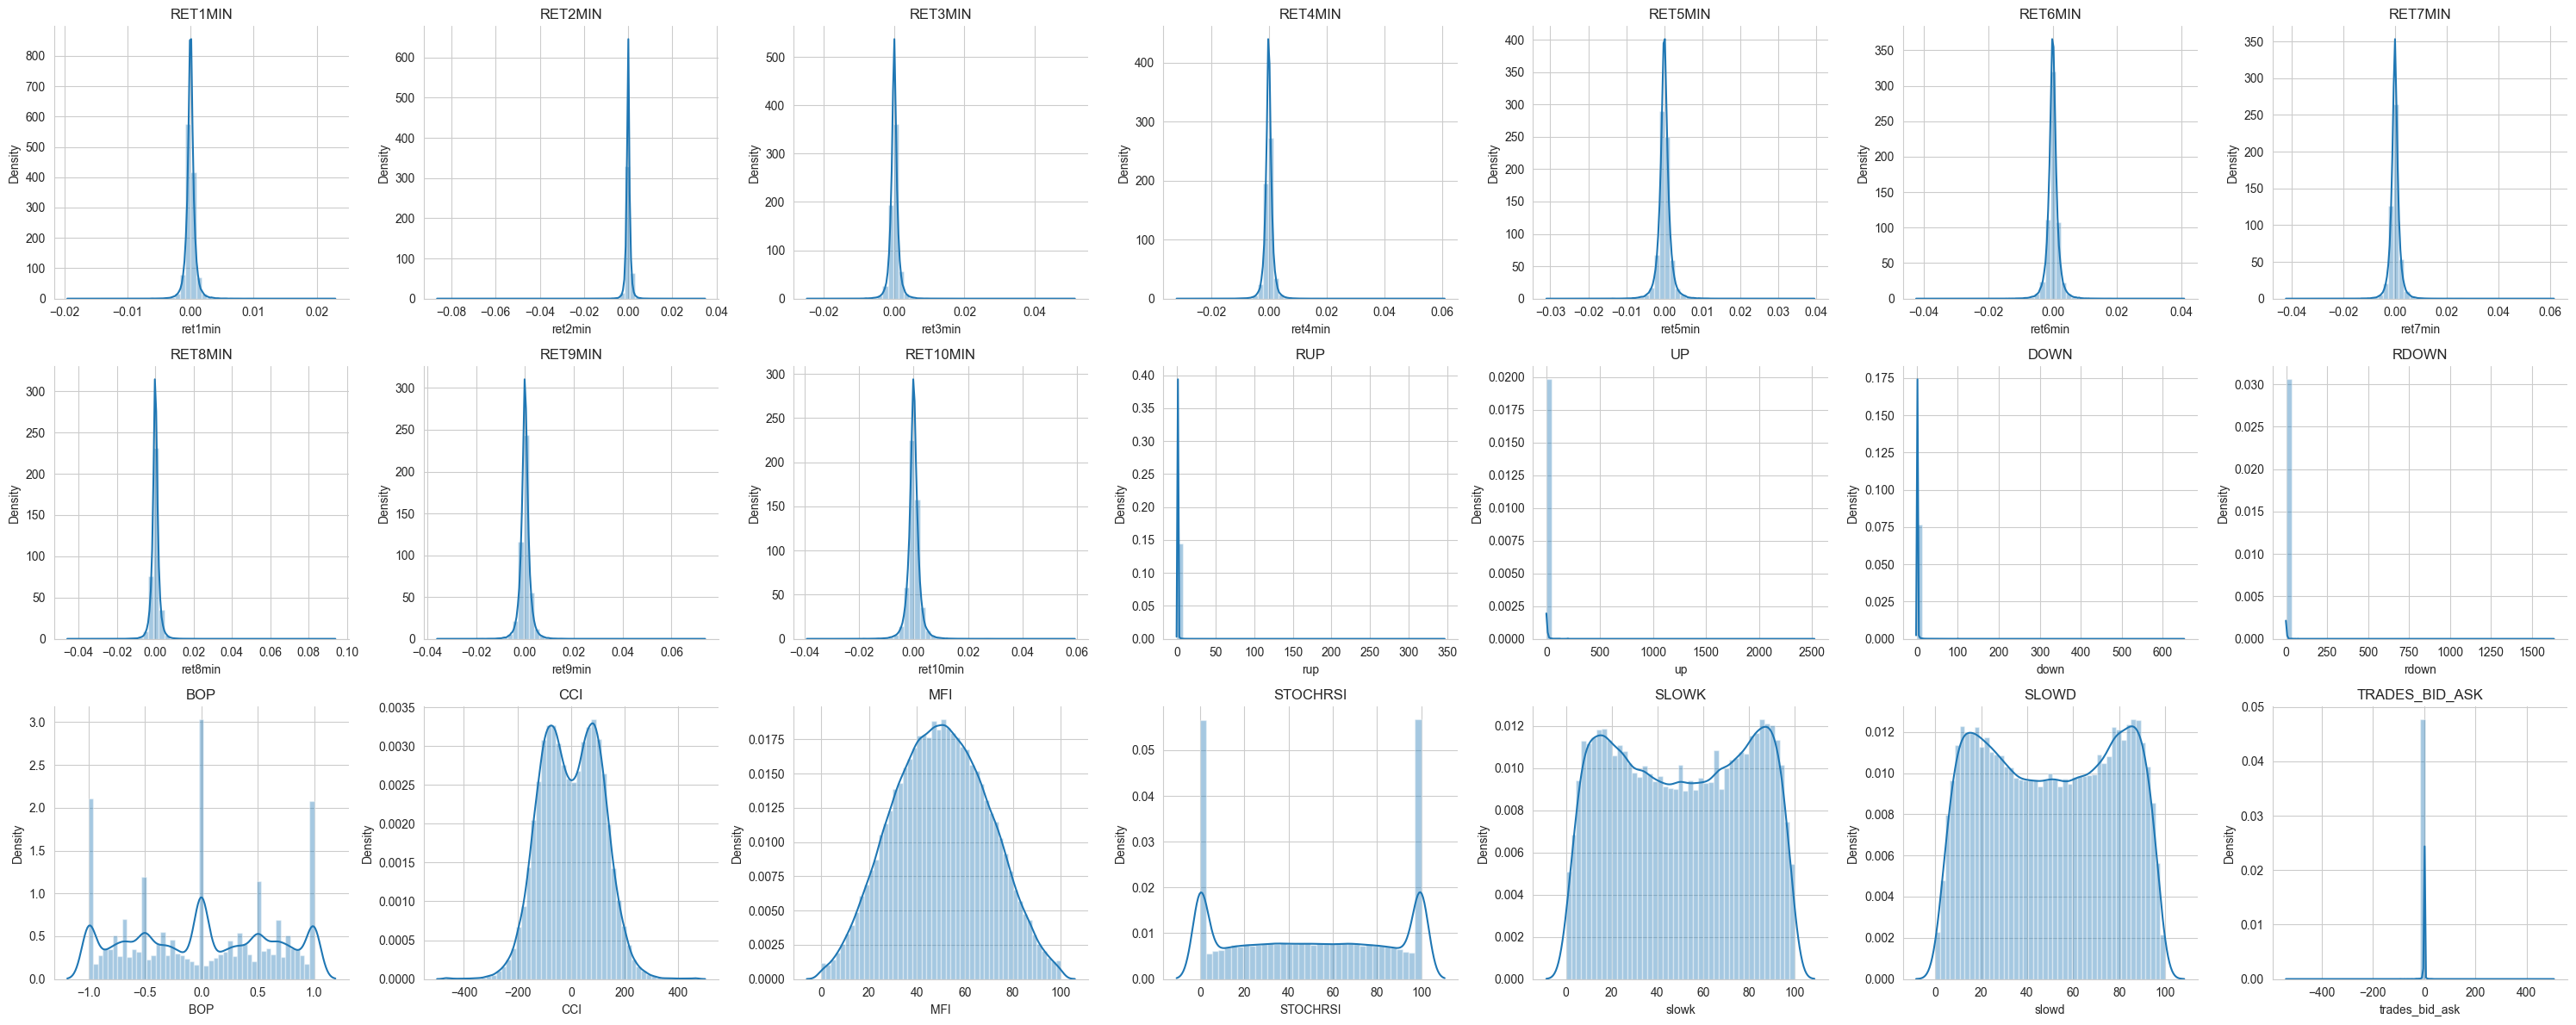

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(30, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.distplot(sample[feature], ax=axes[i])
    axes[i].set_title(feature.upper())
    
sns.despine()
fig.tight_layout()

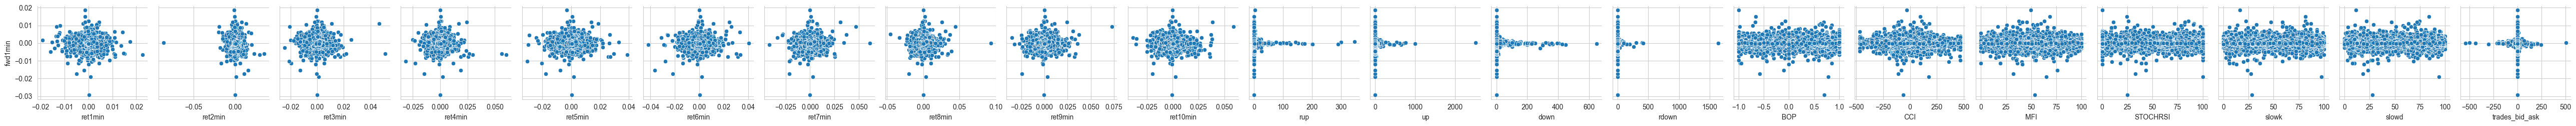

In [44]:
sns.pairplot(sample, y_vars=['fwd1min'], x_vars=features);

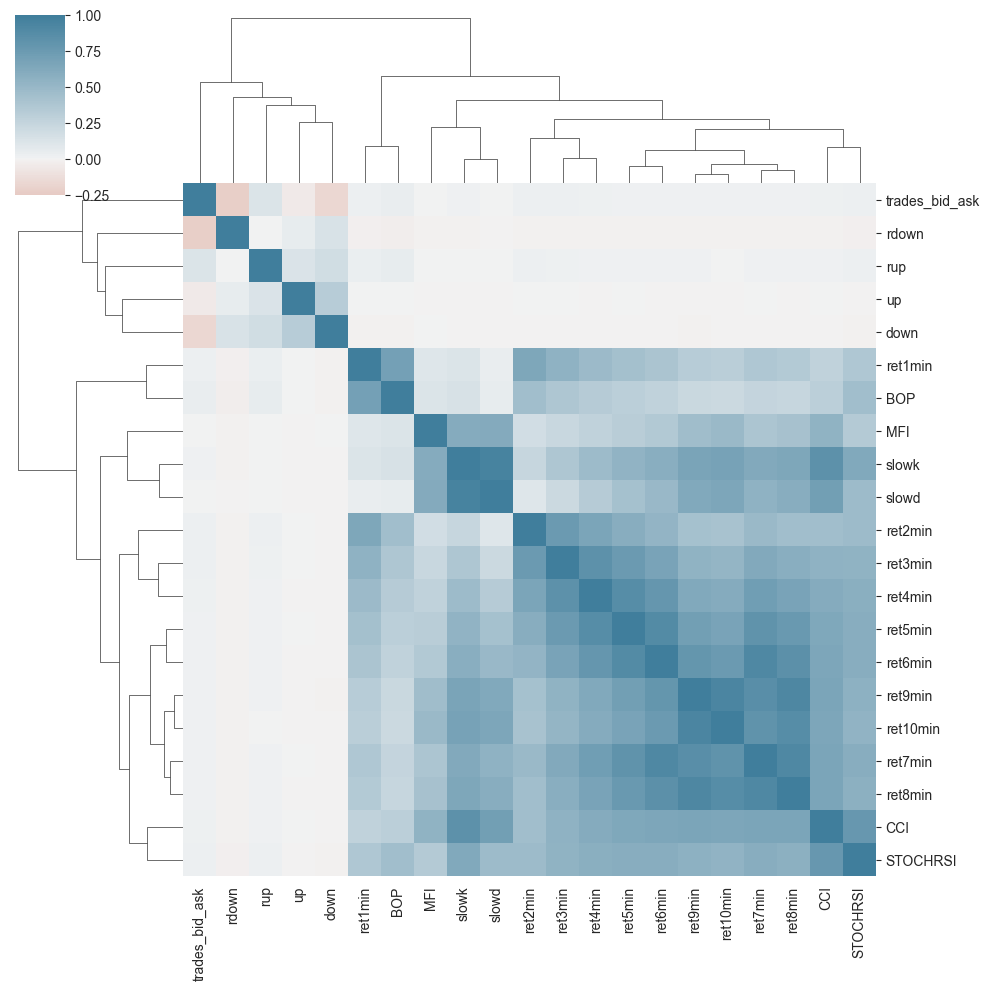

In [45]:
corr = sample.loc[:, features].corr()
sns.clustermap(corr, cmap = sns.diverging_palette(20, 230, as_cmap=True),
              center=0, vmin=-.25);

In [46]:
ic = {}
for feature in tqdm(features):
    df = data[['fwd1min', feature]].dropna()
    by_day = df.groupby(df.index.get_level_values('date_time').date) # calc per min is very time-consuming
    ic[feature] = by_day.apply(lambda x: spearmanr(x.fwd1min, x[feature])[0]).mean()
ic = pd.Series(ic)

100%|██████████| 21/21 [02:43<00:00,  7.80s/it]


In [47]:
ic.sort_values()

STOCHRSI         -0.015178
ret4min          -0.013636
CCI              -0.012663
ret5min          -0.012534
ret3min          -0.012235
ret9min          -0.010546
ret8min          -0.009978
ret2min          -0.009834
ret7min          -0.009678
ret10min         -0.009596
ret1min          -0.009468
ret6min          -0.009047
rup              -0.008965
BOP              -0.006312
slowk            -0.005720
trades_bid_ask   -0.005406
MFI              -0.003847
slowd            -0.001772
up               -0.000832
down              0.000038
rdown             0.010978
dtype: float64

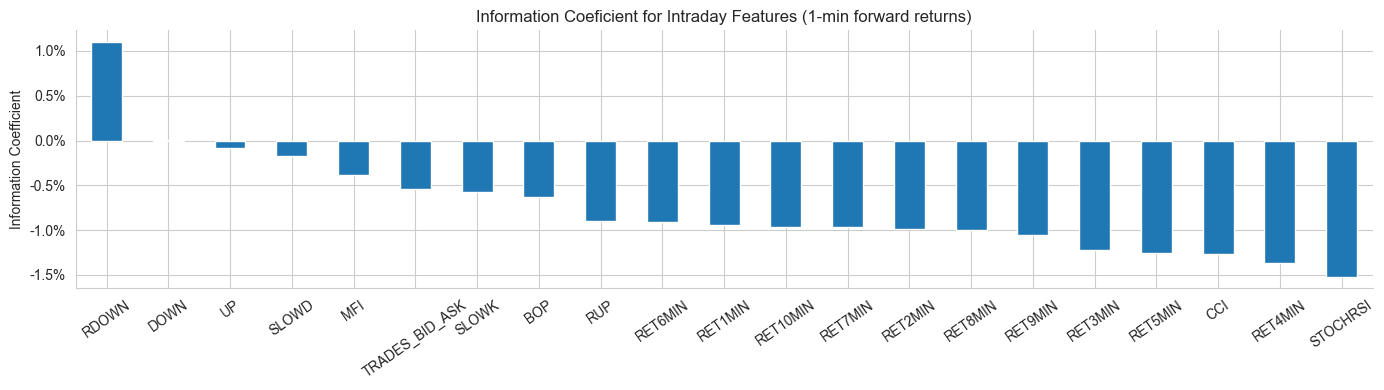

In [48]:
title = 'Information Coeficient for Intraday Features (1-min forward returns)'
ic.index = ic.index.map(str.upper)
ax = ic.sort_values(ascending=False).plot.bar(figsize=(14, 4), title=title, rot=35)
ax.set_ylabel('Information Coefficient')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 
sns.despine()
plt.tight_layout();

### Store results

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30875649 entries, ('AAL', Timestamp('2015-01-02 09:30:00')) to ('YHOO', Timestamp('2017-06-16 15:59:00'))
Data columns (total 25 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            int64  
 1   minute          int32  
 2   ret1min         float64
 3   ret2min         float64
 4   ret3min         float64
 5   ret4min         float64
 6   ret5min         float64
 7   ret6min         float64
 8   ret7min         float64
 9   ret8min         float64
 10  ret9min         float64
 11  ret10min        float64
 12  fwd1min         float64
 13  up              float64
 14  down            float64
 15  rup             float64
 16  rdown           float64
 17  BOP             float64
 18  CCI             float64
 19  MFI             float64
 20  STOCHRSI        float64
 21  slowd           float64
 22  slowk           float64
 23  NATR            float64
 24  trades_bid_ask  float64
dtypes: float64(23), int32(1

In [ ]:
data.drop(['date', 'up', 'down'], axis=1).to_hdf(data_path, 'model_data')